In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances, jensen_shannon_divergence

from general_tools.strings import trim_content_after_last_dot

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
seed = 42
np.random.seed(seed)

In [24]:
# LOAD (Synthetic) Point-Cloud Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/ae_emd_1c_gan_chair_2048_pts_epoch_10.npz'
# in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/mit_3dgan_1K_synthetic_samples/point_clouds/2048/chair.npz'

save_figs = False
look_only = 1000 # speed up

syn_data = np.load(in_f)
syn_data = syn_data[syn_data.keys()[0]]
syn_data = syn_data[:look_only]

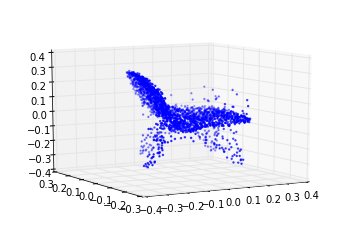

In [26]:
Point_Cloud(syn_data[1]).plot();

In [27]:
# for i, pc in enumerate(syn_data):
#     syn_data[i] = Point_Cloud(pc).center_in_unit_sphere().points
#     temp = syn_data[i]
#     syn_data[i] = temp[:, [0,2,1]]
#     syn_data[i] = syn_data[i]

assert(abs(np.min(syn_data)) <= 0.5 and abs(np.max(syn_data)) <=0.5)

In [28]:
session = tf.Session()
distance_type = 'EMD'
all_dists = point_cloud_distances(syn_data, 10, session, distance_type)

227.914


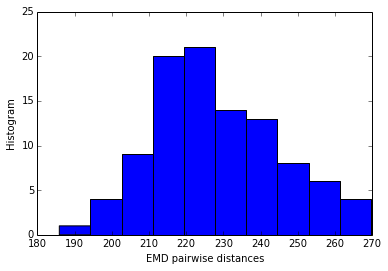

In [29]:
print np.mean(all_dists)
plt.hist(all_dists)[2]
plt.xlabel(distance_type + ' pairwise distances')
plt.ylabel('Histogram')
if save_figs:
    plt.savefig(trim_content_after_last_dot(in_f) + '_dist_hist.png')

In [30]:
mentropy, grid_var = entropy_of_occupancy_grid(syn_data, 32)
print mentropy

0.0626971545186


In [23]:
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/gt_all_chair.npz'
gt_data = np.load(in_f)
gt_data = gt_data[gt_data.keys()[0]]
gt_data = gt_data[:look_only]
_, gt_grid_var = entropy_of_occupancy_grid(gt_data, 32)